# Understanding your Deep Learning Models with Explainable AI

**Exercise - MLPM course 2024**

*Date: 21.11.2024*<br>

# Warm-up: Implementation of 3 basic methods

Try to implement from scratch the 3 following feature attribution methods:
1. **Gradient**. Parameters:
  - x (Tensor): input sample, (B * C * W * H)
  - model (torch.nn.Module): model
  - target (int): output dimension to explain
  - Output: gradient attributions (np.ndarray), (B * W * H) (averaged over channels)

2. **Input**$\times$**Gradient**. Parameters:
  - x (Tensor): input sample, (B * C * W * H)
  - model (torch.nn.Module): model
  - target (int): output dimension to explain
  - Output: gradient attributions (np.ndarray), (B * W * H) (averaged over channels)

3. **Occlusion**. Parameters:
  - x (Tensor): input sample, (B * C * W * H)
  - model (torch.nn.Module): model
  - target (int): output dimension to explain
  - baseline (float): reference value used for masking (default: zeros), (C * w * w)
  - w (int): for 2D inputs (e.g. images), size of the occlusion window
  - Output: gradient attributions (np.ndarray), (B * W * H) (averaged over channels)

## Example use case: Natural image classification on ImageNet

In [4]:
import torch
import numpy as np
import matplotlib.pyplot as plt

In [5]:
# Retrieve pretrained InceptionV3 network from torch hub
model = torch.hub.load('pytorch/vision:v0.10.0', 'inception_v3', pretrained=True)
model.eval()

Using cache found in C:\Users\vikto/.cache\torch\hub\pytorch_vision_v0.10.0


Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [6]:
# Download ImageNet class names
!wget https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt
with open("imagenet_classes.txt", "r") as f:
  categories = [s.strip() for s in f.readlines()]

'wget' n'est pas reconnu en tant que commande interne
ou externe, un programme ex�cutable ou un fichier de commandes.


In [7]:
print(categories)

['tench', 'goldfish', 'great white shark', 'tiger shark', 'hammerhead', 'electric ray', 'stingray', 'cock', 'hen', 'ostrich', 'brambling', 'goldfinch', 'house finch', 'junco', 'indigo bunting', 'robin', 'bulbul', 'jay', 'magpie', 'chickadee', 'water ouzel', 'kite', 'bald eagle', 'vulture', 'great grey owl', 'European fire salamander', 'common newt', 'eft', 'spotted salamander', 'axolotl', 'bullfrog', 'tree frog', 'tailed frog', 'loggerhead', 'leatherback turtle', 'mud turtle', 'terrapin', 'box turtle', 'banded gecko', 'common iguana', 'American chameleon', 'whiptail', 'agama', 'frilled lizard', 'alligator lizard', 'Gila monster', 'green lizard', 'African chameleon', 'Komodo dragon', 'African crocodile', 'American alligator', 'triceratops', 'thunder snake', 'ringneck snake', 'hognose snake', 'green snake', 'king snake', 'garter snake', 'water snake', 'vine snake', 'night snake', 'boa constrictor', 'rock python', 'Indian cobra', 'green mamba', 'sea snake', 'horned viper', 'diamondback', 

'wget' n'est pas reconnu en tant que commande interne
ou externe, un programme ex�cutable ou un fichier de commandes.


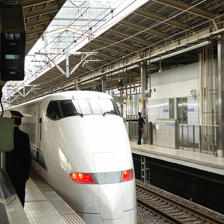

In [8]:
# Load example image from ImageNet
!wget https://raw.githubusercontent.com/EliSchwartz/imagenet-sample-images/bc69043e2862758a1906c6a24a792bb28c6bb2ff/n02917067_bullet_train.JPEG -O img.jpg
from PIL import Image
from torchvision import transforms
input_image = Image.open('img.jpg')
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model
input_image = input_image.resize((256,256)).crop((16, 16, 256-16, 256-16))
input_image


In [9]:
probs = model(input_batch).softmax(dim=1)
y_pred = probs.argmax(dim=1).item()
print(f"Predicted class: {categories[y_pred]} (p = {probs.max().item()})")

Predicted class: bullet train (p = 0.9999780654907227)


## Gradient

In [10]:
def gradient(
    x: torch.Tensor,
    model: torch.nn.Module,
    target: int,
) -> np.ndarray:

    # Enable gradients
    x.requires_grad = True

    # Compute the gradient of the output with respect to the input
    ### YOUR CODE HERE ###
    output = model(x)
    target_output = output[:, target]
    target_output.backward()
    grad = x.grad.detach().cpu().numpy()  # Remove batch dimension (shape becomes 3x224x224)
    attribution = np.sum(grad, axis=0)/3 # Compute average across RGB channels
    
    return attribution

In [11]:
%%time
grad = gradient(input_batch, model, y_pred)

CPU times: total: 2.77 s
Wall time: 565 ms


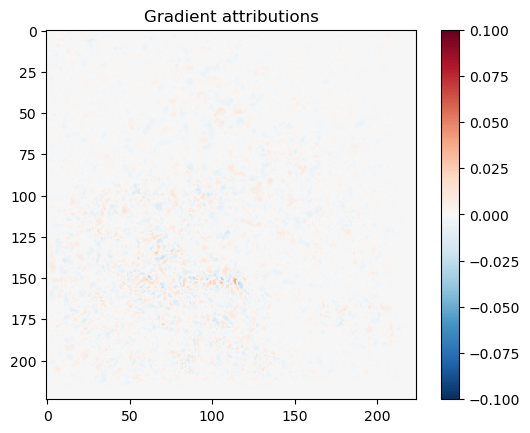

In [12]:
# Visualize attributions as a heatmap
plt.imshow(grad[0], cmap='RdBu_r', vmin=-0.1, vmax=0.1)
plt.title("Gradient attributions")
plt.colorbar()
plt.show()

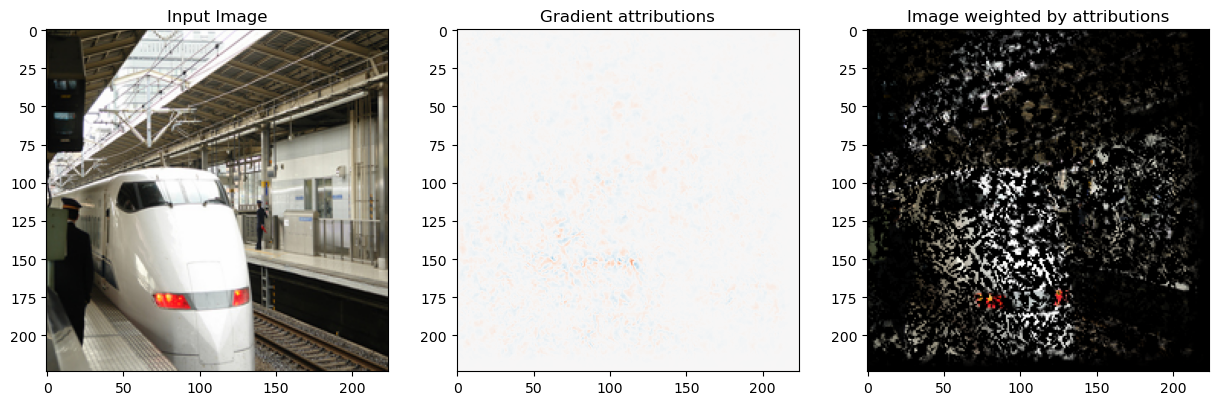

In [13]:
# Visualize them side-by-side with the input image
fig, ax = plt.subplots(1,3, figsize=(15,5))
ax[0].imshow(input_image)
ax[0].set_title("Input Image")
ax[1].imshow(grad[0], cmap='RdBu_r', vmin=-0.1, vmax=0.1)
ax[1].set_title("Gradient attributions")
grad_scaled = np.clip(grad / np.quantile(grad, 0.95), 0, 1)
ax[2].imshow(input_image * grad_scaled[0,:,:,None] / 255)
ax[2].set_title("Image weighted by attributions")
plt.show()

## Input $\times$  Gradient

In [14]:
def inputxgradient(
    x: torch.Tensor,
    model: torch.nn.Module,
    target: int,
) -> np.ndarray:

    ### YOUR CODE HERE ###
    # Enable gradients
    x.requires_grad = True

    # Compute the gradient of the output with respect to the input
    ### YOUR CODE HERE ###
    output = model(x)
    target_output = output[:, target]
    target_output.backward()
    
    attribution = (x * x.grad).mean(dim=1).detach().cpu().numpy()

    return attribution

In [15]:
%%time

inputxgrad = inputxgradient(input_batch, model, y_pred)


CPU times: total: 1.67 s
Wall time: 361 ms


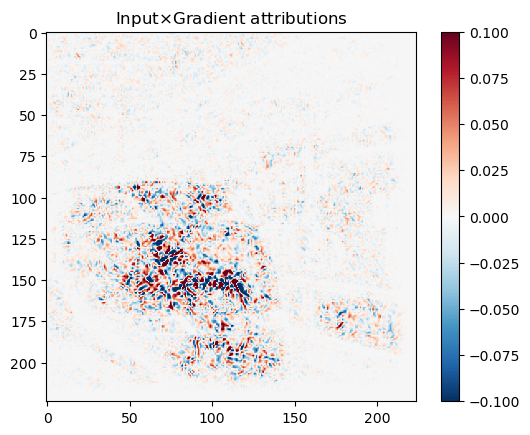

In [16]:
# Visualize attributions as a heatmap
plt.imshow(inputxgrad[0], cmap='RdBu_r', vmin=-0.1, vmax=0.1)
plt.title(r"Input$\times$Gradient attributions")
plt.colorbar()
plt.show()

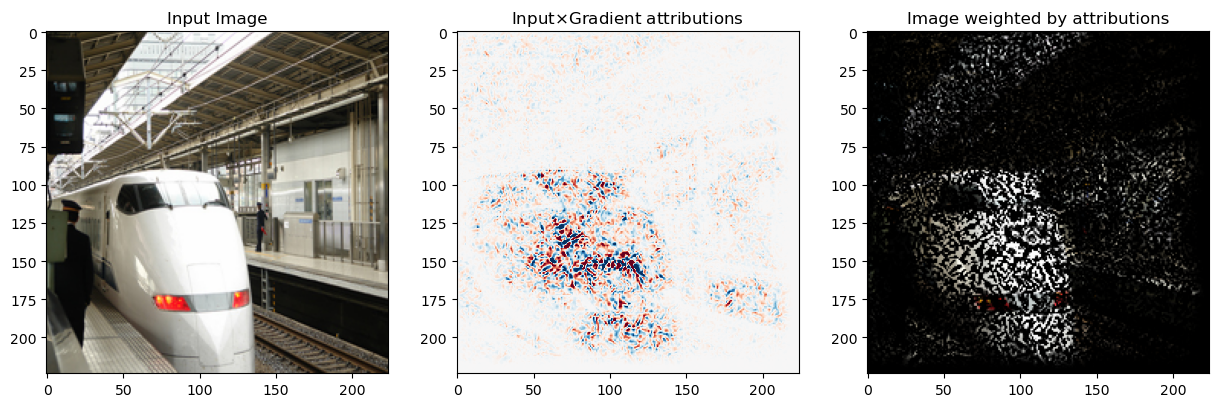

In [17]:
# Visualize them side-by-side with the input image
fig, ax = plt.subplots(1,3, figsize=(15,5))
ax[0].imshow(input_image)
ax[0].set_title("Input Image")
ax[1].imshow(inputxgrad[0], cmap='RdBu_r', vmin=-0.1, vmax=0.1)
ax[1].set_title(r"Input$\times$Gradient attributions")
inputxgrad_scaled = np.clip(inputxgrad / np.quantile(inputxgrad, 0.95), 0, 1)
ax[2].imshow(input_image * inputxgrad_scaled[0,:,:,None] / 255)
ax[2].set_title("Image weighted by attributions")
plt.show()

## Occlusion

In [18]:
def occlusion(
    x: torch.Tensor,
    model: torch.nn.Module,
    target: int,
    baseline: torch.Tensor,
    w: int = 1,
) -> np.ndarray:

    ### YOUR CODE HERE ###
    # Get input dimensions
    B, C, W, H = x.shape    
    attribution = torch.zeros((B, W, H), device=x.device)

    # Precompute original model output for efficiency
    with torch.no_grad():
        output_original = model(x)
        target_original = output_original[:, target]

    # Iterate over all spatial positions
    for i in range(0, W, w):
        print("i :",i, "/",W)
        for j in range(0, H, w):
            # Create occluded input
            x_occluded = x.clone()
            x_occluded[:, :, i:i+w, j:j+w] = baseline[:, :, :min(w, W-i), :min(w, H-j)]

            # Forward pass for occluded input
            with torch.no_grad():  # No need to track gradients
                output_occluded = model(x_occluded)
                target_occluded = output_occluded[:, target]

            # Compute the difference
            delta = (target_original - target_occluded).view(B, 1, 1) # From (B,1,1) 
            attribution[:, i:i+w, j:j+w] += delta # To (B,W,H) after the iterations
    attribution = attribution.detach().cpu().numpy() # Convert to numpy array
    return attribution

In [19]:
%%time
w = 40 # 5 (4 minutes to run), 4 (8 minutes to run)
baseline = torch.zeros_like(input_batch)### YOUR CODE HERE ###
occ = occlusion(input_batch, model, y_pred, baseline=baseline, w=w)

i : 0 / 224
i : 40 / 224
i : 80 / 224
i : 120 / 224
i : 160 / 224
i : 200 / 224
CPU times: total: 20.6 s
Wall time: 4 s


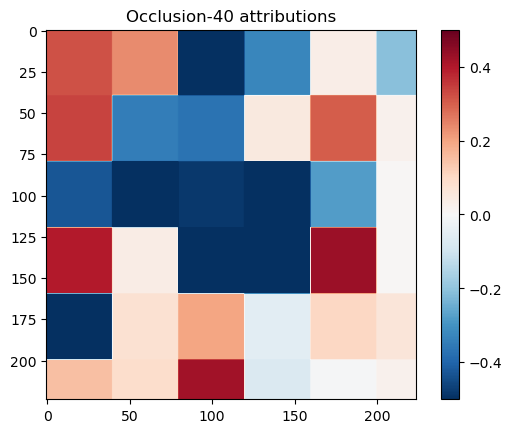

In [20]:
# Visualize attributions as a heatmap
plt.imshow(occ[0], cmap='RdBu_r', vmin=-0.5, vmax=0.5)
plt.title(f"Occlusion-{w} attributions")
plt.colorbar()
plt.show()

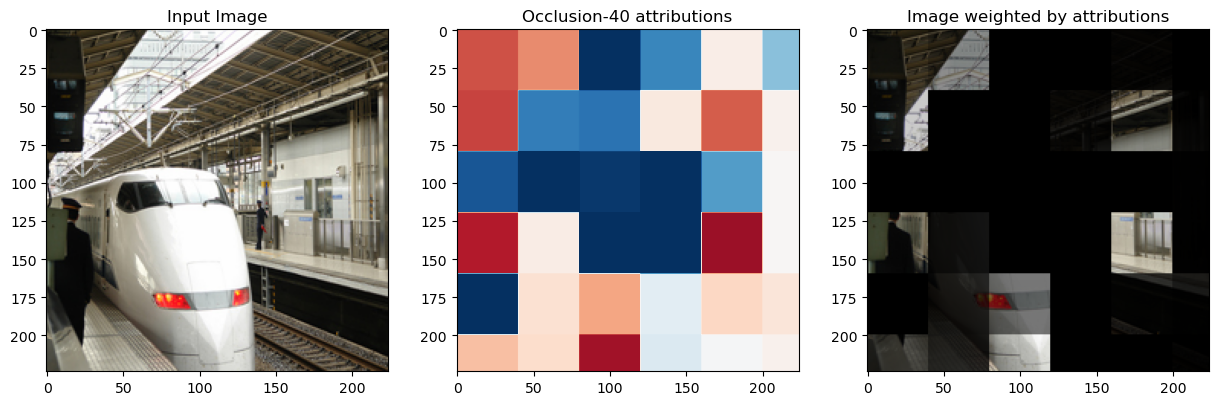

In [21]:
# Visualize them side-by-side with the input image
fig, ax = plt.subplots(1,3, figsize=(15,5))
ax[0].imshow(input_image)
ax[0].set_title("Input Image")
ax[1].imshow(occ[0], cmap='RdBu_r', vmin=-0.5, vmax=0.5)
ax[1].set_title(f"Occlusion-{w} attributions")
occ_scaled = np.clip(occ / np.quantile(occ, 0.95), 0, 1)
ax[2].imshow(input_image * occ_scaled[0,:,:,None] / 255)
ax[2].set_title("Image weighted by attributions")
plt.show()

# Exercise: Investigation of a crack detector

Let us consider the problem of crack detection in wall images. The task is expressed as binary classification.

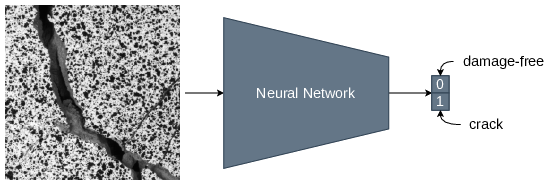

You are given the weights of three trained CNN models (`model_A`, `model_B` and `model_C`), and a test data set with positive images (with cracks) and negative images (without cracks).

**Step 1**. Evaluate the performance of the three models on the test set using relevant performance metrics.

**Step 2**. Can you trust the outcomes of these models? Investigate the predictions of each model using at least two different explainable AI (XAI) techniques and report your findings.

**Step 3**. Which of the three models would you choose to use in production?

**Step 4**. For the two other models, how could you explain what happened? Propose ideas to avoid this kind of problems and build more trustworthy models in the future.

Code for data and model loading is given below.

Some useful XAI libraries:

* [captum](https://github.com/pytorch/captum)
* [pytorch-grad-cam](https://github.com/jacobgil/pytorch-grad-cam)
* [lime](https://github.com/marcotcr/lime)
* [shap](https://github.com/shap/shap)
* [xplique](https://github.com/deel-ai/xplique)
* [iNNvestigate](https://github.com/albermax/innvestigate)
* ...and many more!

Modules can be installed in colab using e.g. `!pip install captum`.

## 1. Set up dataset and models

In [22]:
!git clone https://github.com/EPFL-IMOS/IMC-HOW-XAI.git

fatal: destination path 'IMC-HOW-XAI' already exists and is not an empty directory.


In [23]:
base_path = "./IMC-HOW-XAI"  # CHANGE THIS PATH IF NEEDED

### Data and model loading code

In [24]:
import os
import matplotlib.pyplot as plt
import cv2
import random
import numpy as np
import torch
from torch import nn
from torch.utils.data import ConcatDataset, Dataset
import torchvision
from torchvision import transforms as T
from torchvision.transforms import functional as F

# Data transformations
class Compose:
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image, target=None):
        for t in self.transforms:
            image, target = t(image, target)
        return image, target

class ToTensor:
    def __call__(self, image, target=None):
        image = F.to_tensor(image)
        if target is not None:
            target = torch.as_tensor(target, dtype=torch.int64)
        return image, target

class RandomResize:
    def __init__(self, min_size, max_size=None):
        self.min_size = min_size
        if max_size is None:
            max_size = min_size
        self.max_size = max_size

    def __call__(self, image, target=None):
        size = random.randint(self.min_size, self.max_size)
        image = F.resize(image, size)
        if target is not None:
            target = F.resize(target.unsqueeze(0), size, interpolation=F.InterpolationMode.NEAREST).squeeze(0)
        return image, target


class RandomHorizontalFlip:
    def __init__(self, flip_prob):
        self.flip_prob = flip_prob

    def __call__(self, image, target=None):
        if random.random() < self.flip_prob:
            image = F.hflip(image)
            if target is not None:
                target = F.hflip(target)
        return image, target


class RandomVerticalFlip:
    def __init__(self, flip_prob):
        self.flip_prob = flip_prob

    def __call__(self, image, target=None):
        if random.random() < self.flip_prob:
            image = F.vflip(image)
            if target is not None:
                target = F.vflip(target)
        return image, target

def get_train_transform(crop_size=64, size=256):
    transforms = [
        ToTensor(),
        RandomResize(size),
        RandomHorizontalFlip(flip_prob=0.5),
        RandomVerticalFlip(flip_prob=0.5)
    ]
    return Compose(transforms)

def get_val_transform(crop_size=64, size=256):
    transforms = [
        ToTensor(),
        RandomResize(size)
    ]
    return Compose(transforms)

In [25]:
# Dataset class
TRAIN_IMAGES_POSITIVE = [
    "train_positive"
]

TRAIN_IMAGES_NEGATIVE = [
    "train_negative"
]

TRAIN_IMAGES = TRAIN_IMAGES_POSITIVE + TRAIN_IMAGES_NEGATIVE

VAL_IMAGES_POSITIVE = [
    "val_positive"
]

VAL_IMAGES_NEGATIVE = [
    "val_negative"
]

VAL_IMAGES = VAL_IMAGES_POSITIVE + VAL_IMAGES_NEGATIVE

TEST_IMAGES_POSITIVE = [
    "test_positive"
]

TEST_IMAGES_NEGATIVE = [
    "test_negative"
]

TEST_IMAGES = TEST_IMAGES_POSITIVE + TEST_IMAGES_NEGATIVE

SEED = 42


class DICCracksDatasetFold(Dataset):
    def __init__(self, root, fold="train", segmentation=True, transform=None):
        """
        fold: train, val or test
        """
        self.root = root
        self.fold = fold
        self.segmentation = segmentation
        self.images = sorted(os.listdir(os.path.join(root, fold)))

        if os.path.exists(os.path.join(root, fold + "_GT")):
            self.masks = sorted(os.listdir(os.path.join(root, fold + "_GT")))
        else:
            self.masks = [None] * len(self.images)

        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        mask = self.masks[idx]

        image = cv2.imread(os.path.join(self.root, self.fold, image))
        if mask is not None:
            mask = cv2.imread(os.path.join(self.root, self.fold + "_GT", mask), cv2.IMREAD_GRAYSCALE) / 255
        else:
            mask = np.zeros((image.shape[0], image.shape[1]), dtype="uint8")

        if self.transform is not None:
            image, mask = self.transform(image, mask)

        if not self.segmentation:
            mask = mask.max().item()  # binary classification label

        return image, mask, self.images[idx]


class DICCracksDataset(ConcatDataset):
    def __init__(self, root, fold="train", segmentation=True, positive_only=False, negative_only=False, **kwargs):
        assert fold in ["train", "val", "test"], f"fold {fold} not in train, val or test"

        if fold == "val":
            if positive_only:
                self.folds = VAL_IMAGES_POSITIVE
            elif negative_only:
                self.folds = VAL_IMAGES_NEGATIVE
            else:
                self.folds = VAL_IMAGES
        elif fold == "test":
            if positive_only:
                self.folds = TEST_IMAGES_POSITIVE
            elif negative_only:
                self.folds = TEST_IMAGES_NEGATIVE
            else:
                self.folds = TEST_IMAGES
        elif fold == "train":
            if positive_only:
                self.folds = TRAIN_IMAGES_POSITIVE
            elif negative_only:
                self.folds = TEST_IMAGES_NEGATIVE
            else:
                self.folds = TRAIN_IMAGES
        else:
            raise NotImplementedError()

        # initialize a concat dataset with the corresponding folds
        super().__init__(
            [
                DICCracksDatasetFold(root, fold, segmentation, **kwargs)
                for fold in self.folds
            ]
        )

In [26]:
ds_test = DICCracksDataset(
    root=os.path.join(base_path, "crack_dataset"),
    fold="test",
    transform=get_val_transform(),
    segmentation=False
)

batch_size = 8
test_loader = torch.utils.data.DataLoader(
    ds_test, batch_size=batch_size, drop_last=False
)

### Display a test image

Label =  1


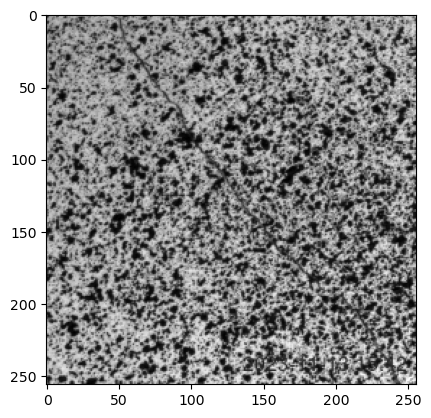

In [27]:
img, label, _ = ds_test[0]
print("Label = ", label)
plt.imshow(img[0].numpy(), cmap="gray");

### Load the 3 pretrained models

In [28]:
models = {
    "A": os.path.join(base_path, "weights",  "model_A.pth"),
    "B": os.path.join(base_path, "weights", "model_B.pth"),
    "C": os.path.join(base_path, "weights", "model_C.pth")
}

In [29]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [30]:
def build_model(weights):
    # Create VGG11 model
    model = torchvision.models.vgg11()
    # modify average pooling for 256*256 inputs (instead of 224*224)
    model.avgpool = nn.AdaptiveAvgPool2d((8, 8))
    # modify the classification head to use 128 neurons instead of 4096
    (
        model.classifier[0],
        model.classifier[3],
        model.classifier[6],
    ) = (nn.Linear(512 * 8 * 8, 128), nn.Linear(128, 128), nn.Linear(128, 2))

    # Load weights
    model.load_state_dict(torch.load(weights, weights_only=True))
    return model

In [31]:
model_A, model_B, model_C = (build_model(models[id]) for id in ("A", "B", "C"))

## 2. Investigation of the models

### Step 1

**Evaluate the performance of the three models on the test set using relevant performance metrics.**

In [32]:
### YOUR CODE HERE ###
from sklearn.metrics import accuracy_score, precision_score, recall_score

# Three models 
# input : images
# neural network
# output : damage free or cracked
# Performance metrics : Accuracy, Recall, Precision

# y_pred = model(x)
# y_true

def evaluate_model(model, loader, device):
    model.to(device)
    model.eval()

    y_true = []
    y_pred = []

    with torch.no_grad():
        for images, labels, _ in loader:
            images = images.to(device)
            labels = labels.to(device)

            # Get predictions
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)

            # Append to lists
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    # Compute metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='binary')
    recall = recall_score(y_true, y_pred, average='binary')

    return accuracy, precision, recall

# Evaluate each model
results = {}
for model_id, model in zip(["A", "B", "C"], [model_A, model_B, model_C]):
    accuracy, precision, recall = evaluate_model(model, test_loader, device)
    results[model_id] = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
    }

# Print results
for model_id, metrics in results.items():
    print(f"Model {model_id} Results:")
    for metric, value in metrics.items():
        print(f"  {metric}: {value:.4f}")


Model A Results:
  Accuracy: 1.0000
  Precision: 1.0000
  Recall: 1.0000
Model B Results:
  Accuracy: 0.9223
  Precision: 0.9634
  Recall: 0.7900
Model C Results:
  Accuracy: 0.9871
  Precision: 1.0000
  Recall: 0.9600


### Step 2

**Can you trust the outcomes of these models? Investigate the predictions of each model using at least 2 different explainable AI (XAI) techniques and report your findings.**

In [33]:
### YOUR CODE HERE ###

# Perturbation-based: SHAP, LIME, RISE...
# Forward Perturbation

# Gradient or Propagation-based: Grad-CAM, Integrated Gradients, DeepLIFT, LRP...
# Backward Propagation

# Choice : LIME and Grad-CAM




Code for the library lime : [https://github.com/marcotcr/lime/blob/master/doc/notebooks/Tutorial%20-%20images%20-%20Pytorch.ipynb].

In [34]:
# LIME
from lime import lime_image
from skimage.segmentation import mark_boundaries


# Define a wrapper for the PyTorch model
class PyTorchModelWrapper:
    def __init__(self, model):
        self.model = model.eval()
    
    def __call__(self, images):
        """
        Convert images from [0, 1] range to the model's input range.
        """
        images = torch.tensor(images).permute(0, 3, 1, 2).float()  # Convert to NCHW format
        images = images.to(next(self.model.parameters()).device)   # Send to device
        with torch.no_grad():
            outputs = self.model(images)
            probs = torch.nn.functional.softmax(outputs, dim=1)
        return probs.cpu().numpy()

# Instantiate the wrapper for the model
model_wrapper = PyTorchModelWrapper(model_A)

# Initialize LIME ImageExplainer
explainer = lime_image.LimeImageExplainer()

# Get an image from the dataset
img, label, _ = ds_test[0]  # Image and label
img = img.numpy().transpose(1, 2, 0)  # Convert to HWC format for LIME
img = (img - img.min()) / (img.max() - img.min())  # Normalize to [0, 1]

# Explain the prediction
explanation = explainer.explain_instance(
    img,                     # Input image
    model_wrapper,           # Prediction function
    top_labels=2,            # Number of labels to explain
    hide_color=0,            # Pixel value for masked regions
    num_samples=1000         # Number of perturbations to generate
)

# Visualize the explanation for the target class
from skimage.color import label2rgb

target_class = 1  # Assume binary classification
temp, mask = explanation.get_image_and_mask(
    label=target_class,       # Class index to explain
    positive_only=True,       # Show only regions supporting the class
    hide_rest=False,          # Show masked regions as background
    num_features=5,          # Number of superpixels to show
    min_weight=0.0            # Minimum weight for superpixel
)

# Plot the results
img_boundry1 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry1)

c:\Users\vikto\anaconda3\envs\viktorml\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
 66%|██████▌   | 659/1000 [01:16<00:39,  8.65it/s]


KeyboardInterrupt: 

In [ ]:

def plot_LIME(model, img_index):
    model_wrapper = PyTorchModelWrapper(model)
    img, label, _ = ds_test[img_index]  # Image and label
    img = img.numpy().transpose(1, 2, 0)  # Convert to HWC format for LIME
    img = (img - img.min()) / (img.max() - img.min())  # Normalize to [0, 1]
    explainer = lime_image.LimeImageExplainer()
    explanation = explainer.explain_instance(
        img,                     # Input image
        model_wrapper,           # Prediction function
        top_labels=2,            # Number of labels to explain
        hide_color=0,            # Pixel value for masked regions
        num_samples=1000         # Number of perturbations to generate
    )
    target_class = 1  # Assume binary classification
    temp, mask = explanation.get_image_and_mask(
        label=target_class,       # Class index to explain
        positive_only=True,       # Show only regions supporting the class
        hide_rest=False,          # Show masked regions as background
        num_features=5,          # Number of superpixels to show
        min_weight=0.0            # Minimum weight for superpixel
    )
    img_boundry1 = mark_boundaries(temp/255.0, mask)
    plt.imshow(img_boundry1)

    return

In [ ]:
plot_LIME(model_A, 4)

In [ ]:
print(model_A)

In [ ]:
# Grad-CAM
from torchcam.methods import GradCAM

# Function to register the hooks for Grad-CAM
def register_hooks(model, target_layer):
    activations = []
    gradients = []

    # Hook to capture the feature map (activations) after the forward pass
    def save_activation(module, input, output):
        activations.append(output)

    # Hook to capture the gradients during the backward pass
    def save_gradient(module, grad_input, grad_output):
        gradients.append(grad_output[0])  # Gradients w.r.t the output

    # Register the hooks
    target_layer.register_forward_hook(save_activation)
    target_layer.register_backward_hook(save_gradient)

    return activations, gradients

# Grad-CAM function
def grad_cam(model, input_image, target, target_layer, device, activations, gradients):
    # Move input image to device
    input_image = input_image.to(device)

    # Forward pass to get the predictions
    model.eval()
    output = model(input_image.unsqueeze(0))  # Add batch dimension

    # Get the score for the target class
    target_score = output[0, target]

    # Backward pass to get the gradients
    model.zero_grad()
    target_score.backward(retain_graph=True)

    # Get the gradients and activations from the hooks
    last_gradients = activations[-1]  # Last activations from the hook
    last_activations = gradients[-1]  # Last gradients from the hook

    # Compute the weights of each feature map
    weights = torch.mean(last_gradients, dim=(2, 3), keepdim=True)  # Global average pooling
    cam = torch.sum(weights * last_activations, dim=1)  # Weighted sum of feature maps

    # Apply ReLU to the result to keep only positive values
    cam = torch.relu(cam)

    # Normalize the cam between 0 and 1
    cam = cam - cam.min()
    cam = cam / cam.max()

    return cam

#Function to overlay the Grad-CAM on image
def overlay_grad_cam_on_image(image, cam, colormap=cv2.COLORMAP_JET):
    #Resize cam to match image
    cam_resized = cv2.resize(cam.cpu().detach().numpy(), (image.shape[2], image.shape[1]))  # (width, height)

    #Apply colormap to the gradcam heatmap
    cam_colored = cv2.applyColorMap(np.uint8(255*cam_resized), colormap)

    #Convert image to RGB and normalize it 
    image = np.array(image)
    image = np.uint8(255*image)
    image_with_cam = cv2.addWeighted(image, 0.6, cam_colored, 0.4, 0)

    return image_with_cam

#Evaluate the model and visualize the Grad-CAM for each image in the dataloader
def evaluate_and_visualize_grad_cam(model, image, label, device, target_layer):
    model.to(device)
    model.eval()

    # Register hooks to get gradients
    activations, gradients = register_hooks(model, target_layer)

    # Generate Grad-CAM for the image
    cam = grad_cam(model, image, label, target_layer, device, activations, gradients)

    # Overlay the Grad-CAM on the image
    image_with_cam = overlay_grad_cam_on_image(image.cpu().numpy().transpose(1, 2, 0), cam)
    


    # Plot the original image and Grad-CAM result
    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.imshow(image.cpu().numpy().transpose(1, 2, 0))  # Original Image
    plt.title(f"Original Image")
    plt.subplot(1, 2, 2)
    plt.imshow(image_with_cam)  # Image with Grad-CAM
    plt.title(f"Grad-CAM")
    plt.show()

device = torch.device("cpu")  # Set device to CPU, change to 'cuda' for GPU if needed

# Choose the layer you want to use for Grad-CAM (usually the last convolutional layer)
target_layer = model_A.features[18]  # Replace with the correct layer index based on your model

# Get an image from the dataset
img, label, _ = ds_test[0]  # Image and label
# img_tensor = img.float() / 255.0  # Normalize to [0, 1]
# img_tensor = img_tensor.to(device)  # Move to the correct device (GPU or CPU)
# Evaluate and visualize Grad-CAM for all models

evaluate_and_visualize_grad_cam(model_A, img_tensor, label, device, target_layer)


In [ ]:
img, label, _ = ds_test[0]

In [ ]:
# from torchvision import models
import numpy as np
import cv2
import requests
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image, \
    deprocess_image, \
    preprocess_image
from PIL import Image

# model = models.resnet50(pretrained=True)
model = model_A
model.eval()

img, _ , _ = ds_test[0]
img = img.permute(1, 2, 0).numpy()  # Shape: (256, 256, 3)
# img_resized = cv2.resize(img, (224, 224))  # Resize using OpenCV
# image_resized = (image_resized * 255).astype(np.uint8)
# image_url = "https://th.bing.com/th/id/R.94b33a074b9ceeb27b1c7fba0f66db74?rik=wN27mvigyFlXGg&riu=http%3a%2f%2fimages5.fanpop.com%2fimage%2fphotos%2f31400000%2fBear-Wallpaper-bears-31446777-1600-1200.jpg&ehk=oD0JPpRVTZZ6yizZtGQtnsBGK2pAap2xv3sU3A4bIMc%3d&risl=&pid=ImgRaw&r=0"
# img = np.array(Image.open(requests.get(image_url, stream=True).raw))
img = cv2.resize(img, (224, 224))
img = np.float32(img) / 255
input_tensor = preprocess_image(img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

# The target for the CAM is the Bear category.
# As usual for classication, the target is the logit output
# before softmax, for that category.
# targets = [ClassifierOutputTarget(295)]
target_layers = [model_A.features[18]]
with GradCAM(model=model, target_layers=target_layers) as cam:
    grayscale_cams = cam(input_tensor=input_tensor, targets=targets)
    cam_image = show_cam_on_image(img, grayscale_cams[0, :], use_rgb=True)
cam = np.uint8(255*grayscale_cams[0, :])
cam = cv2.merge([cam, cam, cam])
images = np.hstack((np.uint8(255*img), cam , cam_image))
Image.fromarray(images)

In [ ]:
img1, _ , _ = ds_test[0]

image_url = "https://th.bing.com/th/id/R.94b33a074b9ceeb27b1c7fba0f66db74?rik=wN27mvigyFlXGg&riu=http%3a%2f%2fimages5.fanpop.com%2fimage%2fphotos%2f31400000%2fBear-Wallpaper-bears-31446777-1600-1200.jpg&ehk=oD0JPpRVTZZ6yizZtGQtnsBGK2pAap2xv3sU3A4bIMc%3d&risl=&pid=ImgRaw&r=0"
img2 = np.array(Image.open(requests.get(image_url, stream=True).raw))
img2 = cv2.resize(img2, (224, 224))
img2 = np.float32(img2) / 255

# img1.shape
img2.shape

### Step 3

**Which of the three models would you choose to use in production?**


### Step 4

**For the two other models, how could you explain what happened? Propose ideas to avoid this kind of problems and build more trustworthy models in the future.**